In [253]:
import random
from collections import deque

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [254]:
# Utils
class ReplayBuffer:
    def __init__(self, size: int):
        """Replay buffer initialisation

        Args:
            size: maximum numbers of objects stored by replay buffer
        """
        self.size = size
        self.buffer = deque([], size)

    def push(self, transition) -> list:
        """Push an object to the replay buffer

        Args:
            transition: object to be stored in replay buffer. Can be of any type

        Returns:
            The current memory of the buffer (any iterable object e.g. list)
        """
        self.buffer.append(transition)
        return self.buffer

    def sample(self, batch_size: int) -> list:
        """Get a random sample from the replay buffer

        Args:
            batch_size: size of sample

        Returns:
            iterable (e.g. list) with objects sampled from buffer without replacement
        """
        return random.sample(self.buffer, batch_size)


class DQN_raw(nn.Module):
    def __init__(self, layer_sizes: list[int]):
        """
        DQN initialisation

        Args:
            layer_sizes: list with size of each layer as elements
        """
        super().__init__()
        self.layers = nn.ModuleList(
            [nn.Linear(layer_sizes[i], layer_sizes[i + 1]) for i in range(len(layer_sizes) - 1)])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the DQN

        Args:
            x: input to the DQN

        Returns:
            outputted value by the DQN
        """
        for layer in self.layers:
            x = F.relu(layer(x))
        return x


# class DQN_cov(nn.Module):
#
#     def __init__(self, h, w, outputs):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
#         self.bn1 = nn.BatchNorm2d(16)
#         self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
#         self.bn2 = nn.BatchNorm2d(32)
#         self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
#         self.bn3 = nn.BatchNorm2d(32)
#
#         # Number of Linear input connections depends on output of conv2d layers
#         # and therefore the input image size, so compute it.
#         convw = self.conv2d_size_out(self.conv2d_size_out(self.conv2d_size_out(w)))
#         convh = self.conv2d_size_out(self.conv2d_size_out(self.conv2d_size_out(h)))
#         linear_input_size = convw * convh * 32
#         self.head = nn.Linear(linear_input_size, outputs)
#
#     def conv2d_size_out(self, size, kernel_size=5, stride=2):
#         return (size - (kernel_size - 1) - 1) // stride + 1
#
#     # Called with either one element to determine next action, or a batch
#     # during optimization. Returns tensor([[left0exp,right0exp]...]).
#     def forward(self, x):
#         x = x.to(device)
#         x = F.relu(self.bn1(self.conv1(x)))
#         x = F.relu(self.bn2(self.conv2(x)))
#         x = F.relu(self.bn3(self.conv3(x)))
#         return self.head(x.view(x.size(0), -1))


class DQN(nn.Module):
    def __init__(self, layer_params: list[int]):
        """
        DQN initialisation

        Args:
            layer_params: list [input_size, output_size, hidden_size, num_hidden]
        """
        super().__init__()
        # Check the validity of the parameters
        assert all(i > 0 for i in layer_params)
        input_size, output_size, hidden_size, num_hidden = layer_params

        # Input layer: Linear
        self.input_layer = nn.Linear(input_size, hidden_size)

        # Hidden layers: Linear
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_hidden - 1)])

        # Output layers: Linear
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward pass through the DQN

        Args:
            x: input to the DQN

        Returns:
            outputted value by the DQN
        """
        x.to(device)
        x = self.input_layer(x)  # Passing through the input layer
        x = F.relu(x)  # Applying Relu activation

        for layer in self.hidden_layers:
            x = layer(x)  # Passing through each hidden layer
            x = F.relu(x)  # Applying Relu activation

        x = self.output_layer(x)
        return x


def epsilon_greedy(epsilon: float, dqn: DQN, state: torch.Tensor):
    """Sample an epsilon-greedy action according to a given DQN

    Args:
        epsilon: parameter for epsilon-greedy action selection
        dqn: the DQN that selects the action
        state: state at which the action is chosen

    Returns:
        Sampled epsilon-greedy action
    """
    q_values = dqn(state)
    num_actions = q_values.shape[0]
    greedy_act = int(torch.argmax(q_values))
    p = float(torch.rand(1))
    if p > epsilon:
        return greedy_act
    else:
        return random.randint(0, num_actions - 1)


def mean_std(res):
    res = torch.tensor(res)
    means = res.float().mean(0)
    stds = res.float().std(0)

    return means, stds


def simple_policy(state, p_random):
    """
    Simple hand-crafted policy to act in the Cartpole environment.
    Input:
        - state {tensor} - current state of the environment
        - p_random {float} - probability that the action is random
    Output: action {int} - action to perform in the environemnt
    """

    if np.random.random() < p_random:
        return np.random.randint(2)

    else:
        return int(state[2] > 0)


def collect_data(num_episodes, p_random, memory):
    """
    Collect the data to train the predictor model.
    Input:
      - num_episode {int} - number of episodes to collect
      - p_random {float} - probability used for the simple policy
    Output:
      - memory
    """

    # Creating the environment
    env = gym.make('CartPole-v0')

    index = 0

    for i_episode in range(num_episodes):
        # Performing the episode
        state = env.reset()
        state_tensor = torch.tensor(state).reshape(-1).float()
        done = False

        while not done:
            action = simple_policy(state, p_random)
            observation, reward, done, _ = env.step(action)

            # Fill in the data
            reward = torch.tensor([reward])
            action = torch.tensor([action])
            next_state_tensor = torch.tensor(observation).reshape(-1).float()

            memory.push([state_tensor, action, next_state_tensor, reward, torch.tensor([done])])

            state = observation
            state_tensor = next_state_tensor
            index += 1

            if index > len(memory.buffer):
                break

    # Closing the environment
    env.close()

    return memory

def update_target(target_dqn: DQN, policy_dqn: DQN):
    """Update target network parameters using policy network.
    Does not return anything but modifies the target network passed as parameter

    Args:
        target_dqn: target network to be modified in-place
        policy_dqn: the DQN that selects the action
    """

    target_dqn.load_state_dict(policy_dqn.state_dict())


def loss(policy_dqn: DQN, target_dqn: DQN, states: torch.Tensor, actions: torch.Tensor,
         rewards: torch.Tensor, next_states: torch.Tensor, dones: torch.Tensor) -> torch.Tensor:
    """Calculate Bellman error loss
    Args:
        policy_dqn: policy DQN
        target_dqn: target DQN
        states: batched state tensor
        actions: batched action tensor
        rewards: batched rewards tensor
        next_states: batched next states tensor
        dones: batched Boolean tensor, True when episode terminates

    Returns:
        Float scalar tensor with loss value
    """

    bellman_targets = (~dones).reshape(-1) * (target_dqn(next_states)).max(1).values + rewards.reshape(-1)
    q_values = policy_dqn(states).gather(1, actions).reshape(-1)
    return ((q_values - bellman_targets) ** 2).mean()

In [271]:
def raw_process(n, N):
    # Random process
    runs_results = []

    env = gym.make('CartPole-v1')
    for run in tqdm(range(N)):
        print(f"Starting run {run + 1} of {N}")
        policy_net = DQN_raw([4, 2])
        target_net = DQN_raw([4, 2])
        update_target(target_net, policy_net)
        target_net.eval()

        optimizer = optim.SGD(policy_net.parameters(), lr=1.)
        memory = ReplayBuffer(1)

        episode_durations = []

        for i_episode in range(n):

            observation = env.reset()
            state = torch.tensor(observation).float()

            done = False
            terminated = False
            t = 0
            while not (done or terminated):

                # Select and perform an action
                action = epsilon_greedy(1, policy_net, state)

                observation, reward, done, info = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()

                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < 1:
                    transitions = memory.sample(1)
                    state_batch, action_batch, nextstate_batch, reward_batch, dones = (torch.stack(x) for x in
                                                                                       zip(*transitions))
                    # Compute loss
                    mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, nextstate_batch,
                                    dones)
                    # Optimize the model
                    optimizer.zero_grad()
                    mse_loss.backward()
                    optimizer.step()

                if done or terminated:
                    episode_durations.append(t + 1)
                t += 1
            # Update the target network, copying all weights and biases in DQN
            if i_episode % 1 == 0:
                update_target(target_net, policy_net)
        runs_results.append(episode_durations)
    print('Complete')
    return runs_results

In [265]:
def DQN_process(n_runs, eps, n_episodes, f_update, params, memory, sample_size, training_step=10, lr=1e-3):
    runs_results = []
    env = gym.make('CartPole-v1')

    for run in tqdm(range(n_runs)):
        print(f"Starting run {run + 1} of {n_runs}")

        policy_net = DQN(params)
        target_net = DQN(params)
        update_target(target_net, policy_net)

        target_net.eval()

        # Experiences: training data will be sampled from the experiences
        # memory = ReplayBuffer(mem_size)
        episode_durations = []
        optimizer = optim.Adam(policy_net.parameters(), lr=lr)

        for i_episode in range(n_episodes):
            observation = env.reset()
            state = torch.tensor(observation).float()

            done = False
            t = 0

            while not done:
                # Select and perform an action
                action = epsilon_greedy(eps, policy_net, state)

                observation, reward, done, info = env.step(action)
                reward = torch.tensor([reward])
                action = torch.tensor([action])
                next_state = torch.tensor(observation).reshape(-1).float()

                memory.push([state, action, next_state, reward, torch.tensor([done])])

                # Move to the next state
                state = next_state

                # Perform one step of the optimization (on the policy network)
                if not len(memory.buffer) < 1:
                    if sample_size > len(memory.buffer):
                        sample_size = len(memory.buffer)

                    for _ in range(int(training_step)):
                        transitions = memory.sample(sample_size)
                        state_batch, action_batch, next_state_batch, reward_batch, dones = (torch.stack(x) for x in
                                                                                            zip(*transitions))

                        # Compute loss
                        mse_loss = loss(policy_net, target_net, state_batch, action_batch, reward_batch, next_state_batch,
                                        dones)

                        # Optimize the model
                        optimizer.zero_grad()
                        mse_loss.backward()
                        optimizer.step()

                if done:
                    episode_durations.append(t + 1)

                t += 1

            # Update the target network, copying all weights and biases in DQN
            if i_episode % f_update == 0:
                update_target(target_net, policy_net)

            eps = max(eps * eps_decay, eps_min)

        runs_results.append(episode_durations)

    print('Complete')

    return runs_results

In [274]:
num_episodes = 1000
NUM_RUNS = 10
EPSILON = 1
eps_min = 0.05
eps_decay = eps_min ** (1 / (num_episodes - 200))
update_frequency = 128
buffer_size = 1000
dqn_layer_params = [4, 2, 64, 5]
lr = 1e-4
batch_size = 128
training_step = 1

print("Collect experiences")
memory_train = ReplayBuffer(buffer_size)
# memory_train = collect_data(2000, 0.5, memory_train)
print("Done")

# Trained
print("Train agent")
trained_results = DQN_process(NUM_RUNS, EPSILON, num_episodes, update_frequency,
                              dqn_layer_params, memory_train, batch_size, training_step, lr)

Collect experiences
Done
Train agent


  0%|          | 0/3 [00:00<?, ?it/s]

Starting run 1 of 3


 33%|███▎      | 1/3 [02:44<05:28, 164.30s/it]

Starting run 2 of 3


 67%|██████▋   | 2/3 [07:05<03:41, 221.28s/it]

Starting run 3 of 3


100%|██████████| 3/3 [09:21<00:00, 187.24s/it]

Complete


In [275]:
# Random
print("Generate random process results for comparison.")
random_results = raw_process(num_episodes, NUM_RUNS)
print("Done")

Generate random process results for comparison.


  0%|          | 0/3 [00:00<?, ?it/s]

Starting run 1 of 3


 33%|███▎      | 1/3 [00:07<00:14,  7.03s/it]

Starting run 2 of 3


 67%|██████▋   | 2/3 [00:14<00:06,  7.00s/it]

Starting run 3 of 3


100%|██████████| 3/3 [00:20<00:00,  6.99s/it]

Complete
Done


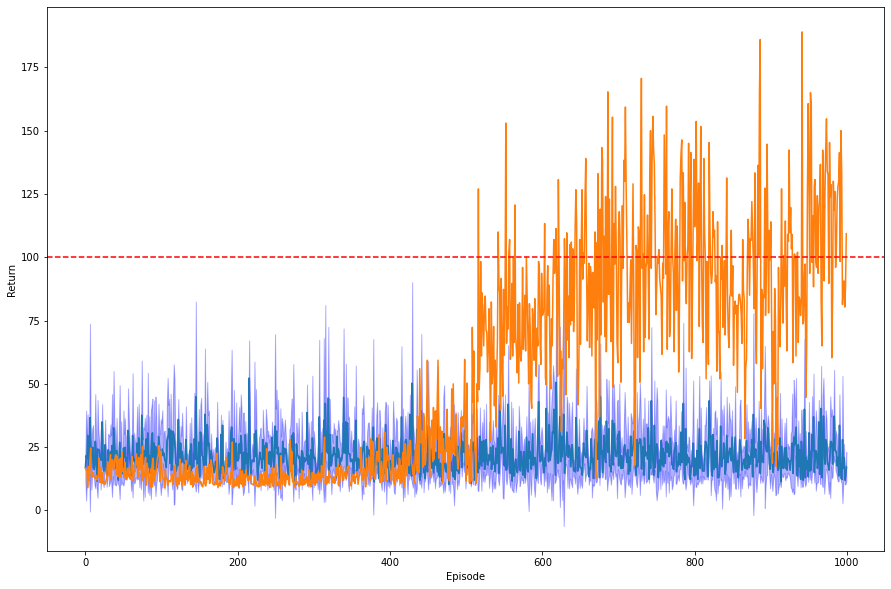

In [277]:
# Plotting the learning curve
plt.figure(figsize=(15, 10))

rand_means, rand_stds = mean_std(random_results)
train_means, train_stds = mean_std(trained_results)

plt.plot(torch.arange(num_episodes), rand_means)
plt.plot(torch.arange(num_episodes), train_means)
plt.ylabel("Return")
plt.xlabel("Episode")

# Plot for random process
plt.fill_between(np.arange(num_episodes), rand_means, rand_means + rand_stds, alpha=0.3, color='b')
plt.fill_between(np.arange(num_episodes), rand_means, rand_means - rand_stds, alpha=0.3, color='b')

# Plot for the standard
plt.axhline(100, c="r", linestyle="--")

# Plot for the trained model
# plt.fill_between(np.arange(num_episodes), train_means, train_means + train_stds, alpha=0.3, color='b')
# plt.fill_between(np.arange(num_episodes), train_means, train_means - train_stds, alpha=0.3, color='b')

plt.savefig("ret_epi.png", bbox_inches='tight')
plt.show()

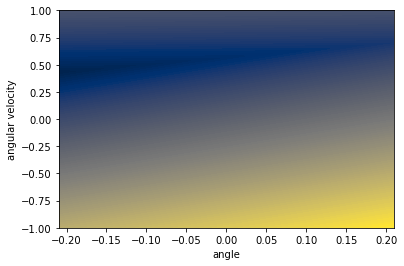

In [14]:
# Visualising the greedy Q-values for a stationary cart in the middle of the track
# 2D plot showing policy as a function of pole angle and angular velocity (omega)

# This plots the policy and Q values according to the network currently
# stored in the variable "policy_net"

# All visualisations provided here are placeholders, and you can modify these plots

# Make sure to include appropriate labels and/or legends when presenting your plot

policy_net = DQN([4, 2])  # randomly initialised, replace with your trained DQN
q = True  # whether q values or greedy policy is visualised

angle_range = .2095  # you may modify this range
omega_range = 1  # you may modify this range

angle_samples = 100
omega_samples = 100
angles = torch.linspace(angle_range, -angle_range, angle_samples)
omegas = torch.linspace(-omega_range, omega_range, omega_samples)

greedy_q_array = torch.zeros((angle_samples, omega_samples))
policy_array = torch.zeros((angle_samples, omega_samples))
for i, angle in enumerate(angles):
    for j, omega in enumerate(omegas):
        state = torch.tensor([0., 0., angle, omega])
        with torch.no_grad():
            q_vals = policy_net(state)
            greedy_action = q_vals.argmax()
            greedy_q_array[i, j] = q_vals[greedy_action]
            policy_array[i, j] = greedy_action
if q:
    plt.contourf(angles, omegas, greedy_q_array.T, cmap='cividis', levels=100)
else:
    plt.contourf(angles, omegas, policy_array.T, cmap='cividis')
plt.xlabel("angle")
plt.ylabel("angular velocity")
plt.show()